In [1]:
import numpy as np
from bisect import bisect_right

#--- 1) Định nghĩa các hệ số của phương pháp ---#

# nodes c_i
c = np.array([0.0,
              1/6,
              11/37,
              11/17,
              13/15,
              1.0])

# a[i][j] = a_{i+1,j+1} với i>j, i,j chạy từ 0..5
a = np.zeros((6,6))
a[1,0] = 1/6
a[2,0] = 44/1369;     a[2,1] = 363/1369
a[3,0] = 3388/4913;   a[3,1] = -8349/4913; a[3,2] = 8140/4913
a[4,0] = -36764/408375; a[4,1] = 767/1125; a[4,2] = -32708/136125; a[4,3] = 210392/408375
a[5,0] = 1697/18876;  a[5,1] = 0.0;        a[5,2] = 50653/116160;  a[5,3] = 299693/1626240; a[5,4] = 3375/11648

# static weights b_i (b6 = 0)
b = np.array([1697/18876,
              0.0,
              50653/116160,
              299693/1626240,
              3375/11648,
              0.0])

# continuous-extension weights b_i(theta)
def b_cont(theta):
    return np.array([
        -866577/824252    * theta**4
        + 1806901/618189  * theta**3
        - 104217/37466    * theta**2
        + theta,

        0.0,

        12308679/5072320 * theta**4
        - 2178079/380424  * theta**3
        + 861101/230560   * theta**2,

        -7816583/10144640 * theta**4
        + 6244423/5325936 * theta**3
        - 63869/293440    * theta**2,

        -624375/217984    * theta**4
        + 982125/190736   * theta**3
        - 1522125/762944  * theta**2,

        296/131          * theta**4
        - 461/131        * theta**3
        + 165/131        * theta**2
    ])


#--- 2) Lớp lưu trữ segment dense output để nội suy history ---#
class DenseSegment:
    def __init__(self, t_n, y_n, k_list, h):
        self.t0 = t_n
        self.y0 = y_n
        self.k  = k_list  # list of 6 mảng derivative tại các stage
        self.h  = h

    def value(self, t):
        θ = (t - self.t0) / self.h
        β = b_cont(θ)
        # y(t) = y_n + h * sum_i β_i * k_i
        out = self.y0.copy()
        for i in range(6):
            out += self.h * β[i] * self.k[i]
        return out


#--- 3) Lịch sử (history) kết hợp φ và các segment để nội suy ---#
class History:
    def __init__(self, phi, t0):
        self.phi = phi
        self.t0  = t0
        self.segs = []  # danh sách DenseSegment

    def append(self, seg: DenseSegment):
        self.segs.append(seg)

    def __call__(self, t):
        if t <= self.t0:
            return self.phi(t)
        # tìm segment phù hợp (t_n ≤ t ≤ t_n+h)
        for seg in reversed(self.segs):
            if seg.t0 <= t <= seg.t0 + seg.h:
                return seg.value(t)
        # nếu quá điểm cuối, trả nội suy của segment cuối
        last = self.segs[-1]
        if last.t0 <= t <= last.t0 + last.h:
            return last.value(t)
        raise ValueError(f"No history available at t={t}")


#--- 4) Solver chính dùng bước cố định h ---#
class CERKSolver:
    def __init__(self, f, tau, phi, t0, tf, h):
        """
        f(t,y,y_delay)    : hàm tính y'
        tau(t,y)          : hàm trả về τ = τ(t,y)
        phi(t)            : history for t ≤ t0
        t0, tf            : thời điểm đầu/cuối
        h                 : bước cố định
        """
        self.f   = f
        self.tau = tau
        self.hist = History(phi, t0)
        self.t0  = t0
        self.tf  = tf
        self.h   = h

    def solve(self):
        t = self.t0
        y = np.array(self.hist.phi(t), dtype=float)
        ts, ys = [t], [y.copy()]

        while t < self.tf - 1e-12:
            h_step = min(self.h, self.tf - t)
            k_list = []

            # 6 stage
            for i in range(6):
                ti = t + c[i] * h_step
                yi = y.copy()
                for j in range(i):
                    yi += h_step * a[i,j] * k_list[j]

                # lấy giá trị trễ
                τ_val = self.tau(ti, yi)
                ytd   = self.hist(ti - τ_val)

                ki = np.array(self.f(ti, yi, ytd), dtype=float)
                k_list.append(ki)

            # lưu segment để nội suy cho các bước kế
            seg = DenseSegment(t, y, k_list, h_step)
            self.hist.append(seg)

            # bước tiếp theo
            increment = sum( b[i] * k_list[i] for i in range(6) )
            y = y + h_step * increment
            t = t + h_step

            ts.append(t); ys.append(y.copy())

        return np.array(ts), np.array(ys)



21

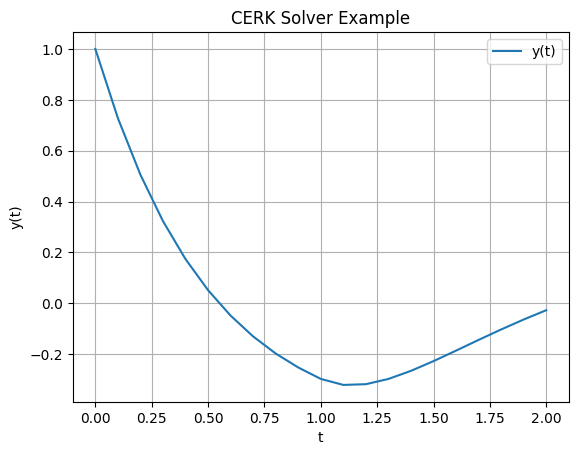

In [7]:
# Ví dụ: y'(t) = -0.5 y(t) + 0.3 y(t - 1.0)
def f_example(t, y, y_delay):
    return -2*y -y_delay

# Delay hằng τ=1
def tau_example(t, y): 
    return 1.0

# History φ(t) = 1.0 cho t ≤ 0
phi_example = lambda t: np.array([1.0])

solver = CERKSolver(
    f   = f_example,
    tau = tau_example,
    phi = phi_example,
    t0  = 0.0,
    tf  = 2.0,
    h   = 0.1
)

ts, ys = solver.solve()

# # In kết quả
# for ti, yi in zip(ts, ys):
#     print(f"{ti:6.3f} → {yi}")
# vẽ đồ thị
import matplotlib.pyplot as plt
plt.plot(ts, ys[:,0], label='y(t)')
plt.title("CERK Solver Example")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.grid()
plt.legend()
len(ts)